# 1. Data Loading

In [75]:
import torch

In [1]:
import pandas as pd
import os

In [77]:
!pip install pandas


[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [4]:
os.listdir('./data')

['customers.csv',
 '.DS_Store',
 'two_tower_checkpoint_1_Feb_A.pth',
 'images',
 'submission-Feb-2-C.csv',
 'articles.csv',
 'customer_embeddings.npz',
 'transactions_train.csv',
 'two_tower_checkpoint_3_Feb_A.pth',
 'article_embeddings.npz',
 'full_training_labels.csv',
 'sample_submission.csv']

In [5]:
customers = pd.read_csv("./data/customers.csv")

In [6]:
articles = pd.read_csv("./data/articles.csv")

In [7]:
import pandas as pd
transactions = pd.read_csv("./data/transactions_train.csv")

# Train/Test Dataset Split

In [56]:
train = transactions[-1250000:-250000]

In [57]:
test = transactions[-250000:]

In [58]:
test_users = set(test.customer_id)

In [59]:
train_users = train['customer_id'].unique()

In [60]:
test_filtered = test[test['customer_id'].isin(train_users)]

# Articles Categorical

In [61]:
import pandas as pd

cols_to_encode = [col for col in articles.columns if col.endswith('_no')]

# Use pd.get_dummies to one-hot encode these columns
articles_encoded = pd.get_dummies(articles, columns=cols_to_encode, prefix=cols_to_encode)

#print(articles_encoded.head())

In [62]:
# Select columns that contain '_no' in their names
columns_with_no = [col for col in articles_encoded.columns if '_no' in col]

# Create a new DataFrame with only those columns
articles_categorical = articles_encoded[columns_with_no]

In [63]:
articles_categorical.index = articles_encoded['article_id']

# Users Categorical

In [64]:
cols_to_encode = ['Active', 'FN', 'club_member_status', 'fashion_news_frequency']

In [65]:
customers_encoded = pd.DataFrame()
mapping_dict = {}
for col in cols_to_encode:
    # 1. Find unique values
    unique_vals = customers[col].unique()
    
    # 2. Create a mapping dictionary (value -> integer code)
    mapping = {val: idx for idx, val in enumerate(unique_vals)}
    mapping_dict[col] = mapping
    print(f"Mapping for '{col}': {mapping}")
    
    # 3. Map the original column to integer codes
    code_col = col + '_code'
    customers[code_col] = customers[col].map(mapping)
    
    # 4. One-hot encode the integer codes
    dummies = pd.get_dummies(customers[code_col], prefix=col)
    
    # Concatenate the dummy variables back into the DataFrame
    customers_encoded = pd.concat([customers_encoded, dummies], axis=1)

#print("\nDataFrame after one-hot encoding:")
#print(customers_encoded)

Mapping for 'Active': {np.float64(nan): 0, np.float64(1.0): 1}
Mapping for 'FN': {np.float64(nan): 0, np.float64(1.0): 1}
Mapping for 'club_member_status': {'ACTIVE': 0, nan: 1, 'PRE-CREATE': 2, 'LEFT CLUB': 3}
Mapping for 'fashion_news_frequency': {'NONE': 0, 'Regularly': 1, nan: 2, 'Monthly': 3}


In [66]:
customers.age /= 100

In [67]:
customers_encoded = pd.concat([customers_encoded, customers[['age']]], axis=1)

In [68]:
customers_encoded.index = customers['customer_id']

# Transaction Features

In [8]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1


In [19]:
import pandas as pd
import numpy as np
from functools import reduce

# --- Prepare the DataFrame ---
# Assume your transactions DataFrame has the following columns:
# ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']
# Ensure t_dat is datetime:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

# Get the last training day from the transactions (assuming the table is for training)
last_training_day = transactions['t_dat'].max()

# Define time windows: None means "all time", otherwise we specify a pd.Timedelta.
time_windows = {
    'last_3d': pd.Timedelta(days=3),
    'last_7d': pd.Timedelta(days=7),
    'last_30d': pd.Timedelta(days=30),
    'last_90d': pd.Timedelta(days=90),
    # 'all_time': None,
}

user_features_list = []    # Will accumulate user-level feature DataFrames per time window
article_features_list = [] # Will accumulate article-level feature DataFrames per time window

for window_name, delta in time_windows.items():
    print(window_name)
    if delta is None:
        df_window = transactions.copy()
    else:
        df_window = transactions[transactions['t_dat'] >= last_training_day - delta].copy()

    print("Compute user-level features")
    # ---------------------------
    # Compute user-level features:
    # ---------------------------
    # Group by customer_id and compute:
    #  - avg_price: average price
    #  - transactions_count: number of transactions (row count)
    #  - sales_channel_id_1_count: count of sales_channel_id==1
    #  - sales_channel_id_2_count: count of sales_channel_id==2
    #  - last_purchase_date: maximum t_dat (to compute days since last purchase)
    #  - active_days: count of unique days with a transaction
    user_group = df_window.groupby('customer_id').agg(
        avg_price=('price', 'mean'),
        transactions_count=('article_id', 'count'),
        sales_channel_id_1_count=('sales_channel_id', lambda x: (x == 1).sum()),
        sales_channel_id_2_count=('sales_channel_id', lambda x: (x == 2).sum()),
        last_purchase_date=('t_dat', 'max'),
        active_days=('t_dat', lambda x: x.dt.date.nunique())
    ).reset_index()
    
    # Compute days since last purchase: difference between last_training_day and last_purchase_date (in days)
    user_group[f'days_since_last_purchase_{window_name}'] = (last_training_day - user_group['last_purchase_date']).dt.days
    
    # Rename aggregated columns to include the window suffix (except for customer_id and the computed days_since_last_purchase which already has the suffix)
    user_group = user_group.rename(columns={
        'avg_price': f'avg_price_{window_name}',
        'transactions_count': f'transactions_count_{window_name}',
        'sales_channel_id_1_count': f'sales_channel_id_1_count_{window_name}',
        'sales_channel_id_2_count': f'sales_channel_id_2_count_{window_name}',
        'active_days': f'active_days_{window_name}'
    })
    # Drop the temporary last_purchase_date column; its info is now in days_since_last_purchase
    user_group.drop(columns='last_purchase_date', inplace=True)
    
    user_features_list.append(user_group)

    print("Compute article-level features")
    # -------------------------------
    # Compute article-level features:
    # -------------------------------
    # Group by article_id and compute:
    #  - avg_price, transactions_count, and sales channel counts.
    article_group = df_window.groupby('article_id').agg(
        avg_price=('price', 'mean'),
        transactions_count=('article_id', 'count'),
        sales_channel_id_1_count=('sales_channel_id', lambda x: (x == 1).sum()),
        sales_channel_id_2_count=('sales_channel_id', lambda x: (x == 2).sum())
    ).reset_index()
    
    article_group = article_group.rename(columns={
        'avg_price': f'avg_price_{window_name}',
        'transactions_count': f'transactions_count_{window_name}',
        'sales_channel_id_1_count': f'sales_channel_id_1_count_{window_name}',
        'sales_channel_id_2_count': f'sales_channel_id_2_count_{window_name}'
    })
    
    article_features_list.append(article_group)

# -------------------------------
# Merge features across time windows
# -------------------------------

# For user-level features, merge on 'customer_id'
user_features = reduce(lambda left, right: pd.merge(left, right, on='customer_id', how='outer'),
                       user_features_list)

# For article-level features, merge on 'article_id'
article_features = reduce(lambda left, right: pd.merge(left, right, on='article_id', how='outer'),
                          article_features_list)

# Optional: Fill missing values (e.g., if a customer or article has no transactions in a window)
user_features.fillna(0, inplace=True)
article_features.fillna(0, inplace=True)

# Print a preview of the results
print("User-level features:")
print(user_features.head())

print("\nArticle-level features:")
print(article_features.head())


last_3d
Compute user-level features
Compute article-level features
last_7d
Compute user-level features
Compute article-level features
last_30d
Compute user-level features
Compute article-level features
last_90d
Compute user-level features
Compute article-level features
User-level features:
                                         customer_id  avg_price_last_3d  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...                0.0   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...                0.0   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...                0.0   
3  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...                0.0   
4  0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...                0.0   

   transactions_count_last_3d  sales_channel_id_1_count_last_3d  \
0                         0.0                               0.0   
1                         0.0                               0.0   
2                         0.0                            

In [20]:
user_features

,customer_id,avg_price_last_3d,transactions_count_last_3d,sales_channel_id_1_count_last_3d,sales_channel_id_2_count_last_3d,active_days_last_3d,days_since_last_purchase_last_3d,avg_price_last_7d,transactions_count_last_7d,sales_channel_id_1_count_last_7d,...,sales_channel_id_1_count_last_30d,sales_channel_id_2_count_last_30d,active_days_last_30d,days_since_last_purchase_last_30d,avg_price_last_90d,transactions_count_last_90d,sales_channel_id_1_count_last_90d,sales_channel_id_2_count_last_90d,active_days_last_90d,days_since_last_purchase_last_90d
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,1.0,0.0,1.0,17.0,0.050831,1,1,0,1,17
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.027102,1,1,0,1,76
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,0.0,0.0,0.0,0.0,0.061,1.0,0.0,...,0.0,1.0,1.0,7.0,0.061000,1,0,1,1,7
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.032186,4,0,4,1,41
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,2.0,1.0,8.0,0.038119,2,0,2,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525070,ffff12aa623c69eae8959d673f1f12ad0194ad760d77fd...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,2.0,0.0,1.0,29.0,0.032356,10,10,0,6,29
525071,ffff61677073258d461e043cc9ed4ed97be5617a920640...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.022017,3,3,0,2,33
525072,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,6.0,0.0,1.0,16.0,0.024418,12,6,6,2,16
525073,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.013119,8,8,0,3,35


In [21]:
article_features

,article_id,avg_price_last_3d,transactions_count_last_3d,sales_channel_id_1_count_last_3d,sales_channel_id_2_count_last_3d,avg_price_last_7d,transactions_count_last_7d,sales_channel_id_1_count_last_7d,sales_channel_id_2_count_last_7d,avg_price_last_30d,transactions_count_last_30d,sales_channel_id_1_count_last_30d,sales_channel_id_2_count_last_30d,avg_price_last_90d,transactions_count_last_90d,sales_channel_id_1_count_last_90d,sales_channel_id_2_count_last_90d
0,108775015,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.003842,3,3,0
1,108775044,0.008458,1.0,0.0,1.0,0.008458,3.0,0.0,3.0,0.008384,19.0,0.0,19.0,0.008108,89,3,86
2,110065001,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.006342,5,5,0
3,110065002,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.005743,6,6,0
4,110065011,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.009305,2.0,2.0,0.0,0.007797,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42293,952267001,0.014780,6.0,3.0,3.0,0.013732,10.0,4.0,6.0,0.014982,41.0,25.0,16.0,0.014982,41,25,16
42294,952938001,0.048924,4.0,0.0,4.0,0.048006,9.0,0.0,9.0,0.048006,9.0,0.0,9.0,0.048006,9,0,9
42295,953450001,0.016932,4.0,0.0,4.0,0.016932,6.0,0.0,6.0,0.016836,17.0,0.0,17.0,0.016836,17,0,17
42296,953763001,0.021678,7.0,0.0,7.0,0.021914,31.0,0.0,31.0,0.021908,35.0,0.0,35.0,0.021908,35,0,35


User-level features for last 30 days: ['avg_price_last_30d', 'transactions_count_last_30d', 'sales_channel_id_1_count_last_30d', 'sales_channel_id_2_count_last_30d', 'active_days_last_30d', 'days_since_last_purchase_last_30d']


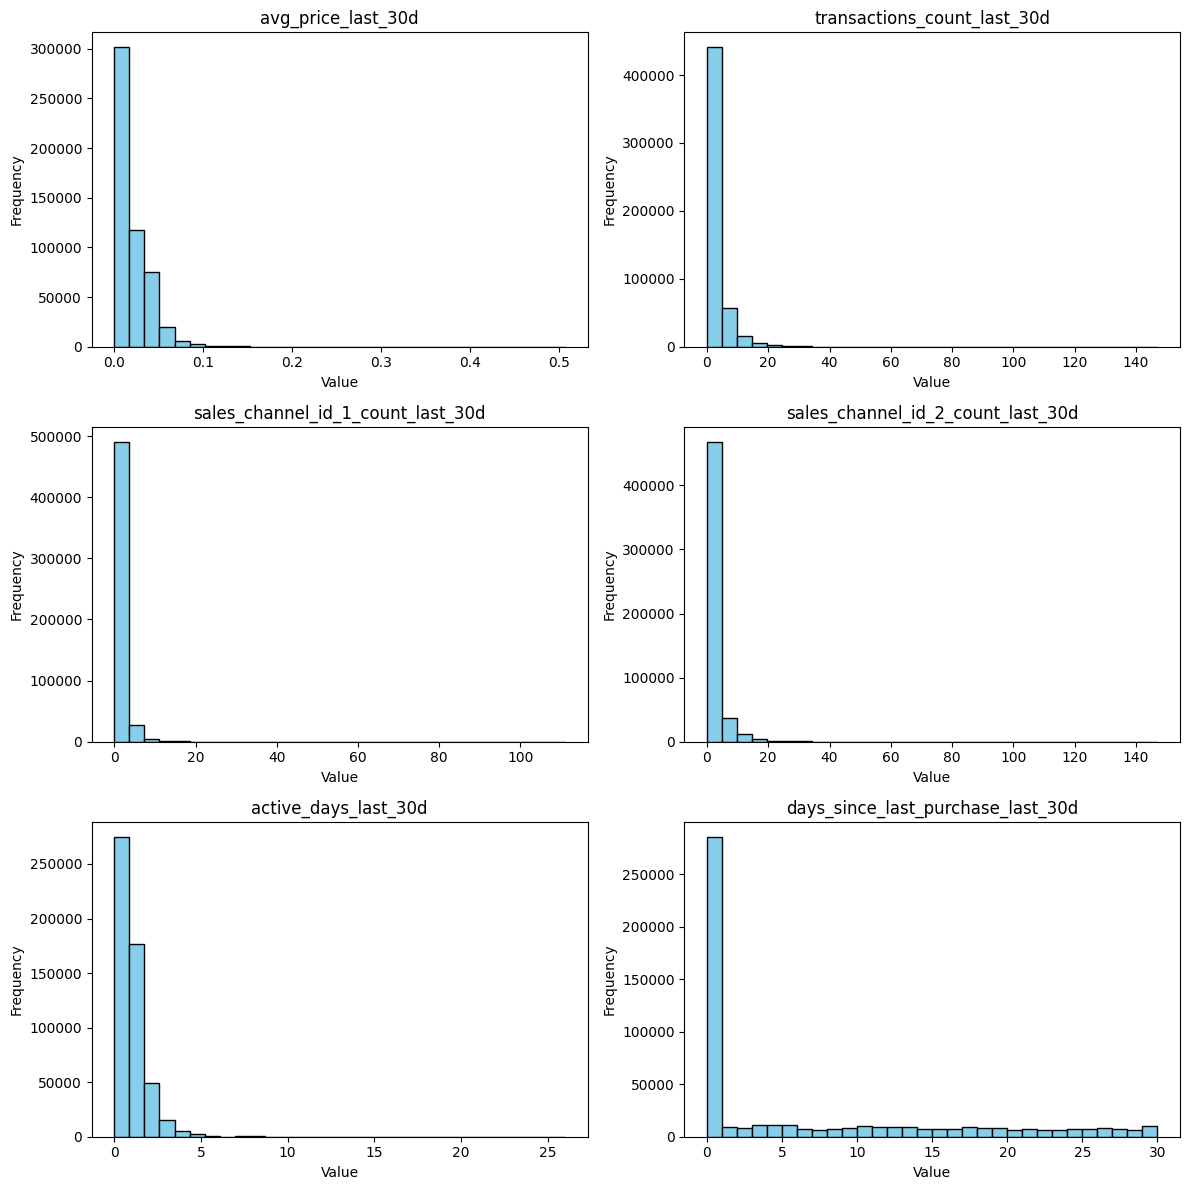

In [22]:
import matplotlib.pyplot as plt

# Select only the user-level feature columns corresponding to the last 3 days
last3d_user_cols = [col for col in user_features.columns if col.endswith('_last_30d')]
print("User-level features for last 30 days:", last3d_user_cols)

# Determine grid size for plotting: 2 columns, and as many rows as needed.
num_plots = len(last3d_user_cols)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*4))
axes = axes.flatten()

# Plot a histogram for each feature
for i, col in enumerate(last3d_user_cols):
    # Drop NaN values if any
    data = user_features[col].dropna()
    axes[i].hist(data, bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Article-level features for last 30 days: ['avg_price_last_30d', 'transactions_count_last_30d', 'sales_channel_id_1_count_last_30d', 'sales_channel_id_2_count_last_30d']


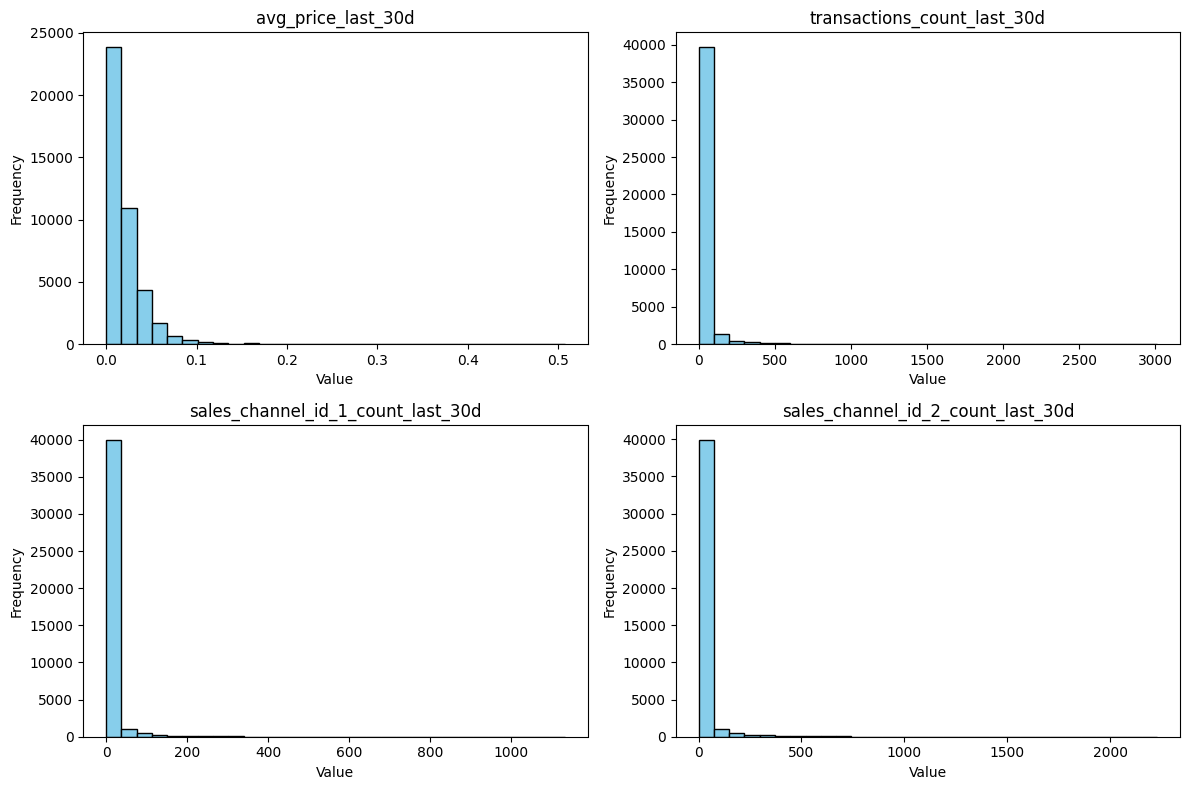

In [23]:
import matplotlib.pyplot as plt

# Select only the user-level feature columns corresponding to the last 3 days
last3d_user_cols = [col for col in article_features.columns if col.endswith('_last_30d')]
print("Article-level features for last 30 days:", last3d_user_cols)

# Determine grid size for plotting: 2 columns, and as many rows as needed.
num_plots = len(last3d_user_cols)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*4))
axes = axes.flatten()

# Plot a histogram for each feature
for i, col in enumerate(last3d_user_cols):
    # Drop NaN values if any
    data = article_features[col].dropna()
    axes[i].hist(data, bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [26]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 37.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 37.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [27]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

# --- Normalize User Features with RobustScaler ---
# Assume user_features is a DataFrame with a 'customer_id' column and the engineered numeric features
user_ids = user_features['customer_id']
numeric_user_features = user_features.drop(columns=['customer_id'])

scaler_user = RobustScaler()
normalized_numeric_user_features = scaler_user.fit_transform(numeric_user_features)

user_features_normalized = pd.DataFrame(
    normalized_numeric_user_features, 
    columns=numeric_user_features.columns, 
    index=user_features.index
)
user_features_normalized.insert(0, 'customer_id', user_ids)

# --- Normalize Article Features with RobustScaler ---
# Assume article_features is a DataFrame with an 'article_id' column and numeric features
article_ids = article_features['article_id']
numeric_article_features = article_features.drop(columns=['article_id'])

scaler_article = RobustScaler()
normalized_numeric_article_features = scaler_article.fit_transform(numeric_article_features)

article_features_normalized = pd.DataFrame(
    normalized_numeric_article_features, 
    columns=numeric_article_features.columns, 
    index=article_features.index
)
article_features_normalized.insert(0, 'article_id', article_ids)

# --- Preview the Results ---
print("Robustly Normalized User Features (first 5 rows):")
print(user_features_normalized.head())

print("\nRobustly Normalized Article Features (first 5 rows):")
print(article_features_normalized.head())


Robustly Normalized User Features (first 5 rows):
                                         customer_id  avg_price_last_3d  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...                0.0   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...                0.0   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...                0.0   
3  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...                0.0   
4  0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...                0.0   

   transactions_count_last_3d  sales_channel_id_1_count_last_3d  \
0                         0.0                               0.0   
1                         0.0                               0.0   
2                         0.0                               0.0   
3                         0.0                               0.0   
4                         0.0                               0.0   

   sales_channel_id_2_count_last_3d  active_days_last_3d  \
0                               0.0 

User-level features for last 30 days: ['avg_price_last_30d', 'transactions_count_last_30d', 'sales_channel_id_1_count_last_30d', 'sales_channel_id_2_count_last_30d', 'active_days_last_30d', 'days_since_last_purchase_last_30d']


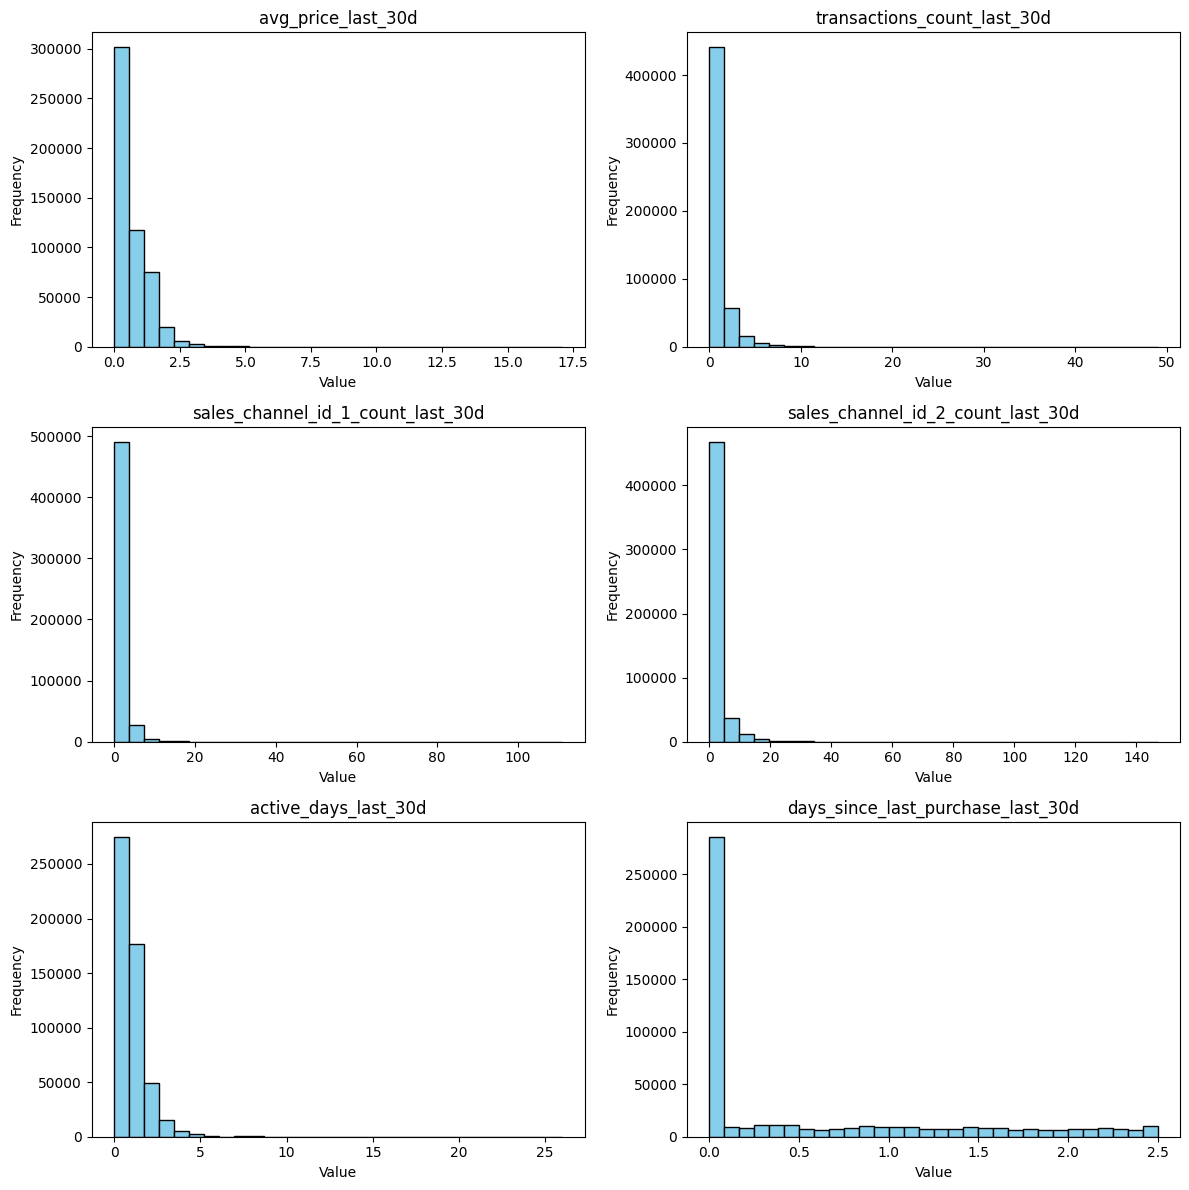

In [28]:
import matplotlib.pyplot as plt

# Select only the user-level feature columns corresponding to the last 3 days
last3d_user_cols = [col for col in user_features_normalized.columns if col.endswith('_last_30d')]
print("User-level features for last 30 days:", last3d_user_cols)

# Determine grid size for plotting: 2 columns, and as many rows as needed.
num_plots = len(last3d_user_cols)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*4))
axes = axes.flatten()

# Plot a histogram for each feature
for i, col in enumerate(last3d_user_cols):
    # Drop NaN values if any
    data = user_features_normalized[col].dropna()
    axes[i].hist(data, bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [30]:
customer_transaction_features = user_features_normalized

In [31]:
article_transaction_features = article_features_normalized

# Training Data Preparation

In [69]:

# Convert all boolean columns to floats in both DataFrames
for df in [customers_encoded, articles_categorical]:
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(float)

/var/folders/pv/1ypdzppd02x4038ctfz2fnkr0000gn/T/ipykernel_84695/1207431484.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[bool_cols] = df[bool_cols].astype(float)


In [73]:

def get_labels(dataset):
    positive_labels = dataset[['customer_id', 'article_id']]
    positive_labels['label'] = 1.0

    customer_positive = positive_labels.groupby('customer_id')['article_id'].apply(set)

    # Define the helper function that will sample a negative article for a row.
    def sample_negative_for_row(row):
        customer = row['customer_id']
        pos_set = customer_positive.get(customer, set())
        
        # Start by sampling a candidate from the entire articles list.
        candidate = np.random.choice(articles['article_id'])
        
        # Iterate until the candidate is not in the customer's positive set.
        while candidate in pos_set:
            candidate = np.random.choice(articles['article_id'])
        
        # Increment our counter and print progress every 1,000 rows.
        sample_negative_for_row.counter += 1
        if sample_negative_for_row.counter % 1000 == 0:
            print(f"Processed {sample_negative_for_row.counter} rows")
        
        return candidate
    
    # Initialize a counter attribute on the function.
    sample_negative_for_row.counter = 0
    
    print("\nStep 2: Generating negative samples for each positive interaction using .apply...")
    # For each row in positive_labels, sample a negative article that is not in the customer's positive set.
    positive_labels['negative_article'] = positive_labels.apply(sample_negative_for_row, axis=1)

    # Step 1: Create a new DataFrame for negative samples
    negative_labels = positive_labels[['customer_id', 'negative_article']].copy()
    negative_labels.rename(columns={'negative_article': 'article_id'}, inplace=True)
    negative_labels['label'] = 0.0
    
    # Step 2: Concatenate positive and negative labels into one DataFrame
    full_labels = pd.concat([positive_labels[['customer_id', 'article_id', 'label']], negative_labels], ignore_index=True)

    return full_labels
    


In [92]:
training_data_30d = get_labels(train)

/var/folders/pv/1ypdzppd02x4038ctfz2fnkr0000gn/T/ipykernel_84695/3114895148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_labels['label'] = 1.0



Step 2: Generating negative samples for each positive interaction using .apply...
Processed 1000 rows
Processed 2000 rows
Processed 3000 rows
Processed 4000 rows
Processed 5000 rows
Processed 6000 rows
Processed 7000 rows
Processed 8000 rows
Processed 9000 rows
Processed 10000 rows
Processed 11000 rows
Processed 12000 rows
Processed 13000 rows
Processed 14000 rows
Processed 15000 rows
Processed 16000 rows
Processed 17000 rows
Processed 18000 rows
Processed 19000 rows
Processed 20000 rows
Processed 21000 rows
Processed 22000 rows
Processed 23000 rows
Processed 24000 rows
Processed 25000 rows
Processed 26000 rows
Processed 27000 rows
Processed 28000 rows
Processed 29000 rows
Processed 30000 rows
Processed 31000 rows
Processed 32000 rows
Processed 33000 rows
Processed 34000 rows
Processed 35000 rows
Processed 36000 rows
Processed 37000 rows
Processed 38000 rows
Processed 39000 rows
Processed 40000 rows
Processed 41000 rows
Processed 42000 rows
Processed 43000 rows
Processed 44000 rows
Pr

/var/folders/pv/1ypdzppd02x4038ctfz2fnkr0000gn/T/ipykernel_84695/3114895148.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_labels['negative_article'] = positive_labels.apply(sample_negative_for_row, axis=1)


In [76]:
test_data_7d = get_labels(test)

/var/folders/pv/1ypdzppd02x4038ctfz2fnkr0000gn/T/ipykernel_84695/3114895148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_labels['label'] = 1.0



Step 2: Generating negative samples for each positive interaction using .apply...
Processed 1000 rows
Processed 2000 rows
Processed 3000 rows
Processed 4000 rows
Processed 5000 rows
Processed 6000 rows
Processed 7000 rows
Processed 8000 rows
Processed 9000 rows
Processed 10000 rows
Processed 11000 rows
Processed 12000 rows
Processed 13000 rows
Processed 14000 rows
Processed 15000 rows
Processed 16000 rows
Processed 17000 rows
Processed 18000 rows
Processed 19000 rows
Processed 20000 rows
Processed 21000 rows
Processed 22000 rows
Processed 23000 rows
Processed 24000 rows
Processed 25000 rows
Processed 26000 rows
Processed 27000 rows
Processed 28000 rows
Processed 29000 rows
Processed 30000 rows
Processed 31000 rows
Processed 32000 rows
Processed 33000 rows
Processed 34000 rows
Processed 35000 rows
Processed 36000 rows
Processed 37000 rows
Processed 38000 rows
Processed 39000 rows
Processed 40000 rows
Processed 41000 rows
Processed 42000 rows
Processed 43000 rows
Processed 44000 rows
Pr

/var/folders/pv/1ypdzppd02x4038ctfz2fnkr0000gn/T/ipykernel_84695/3114895148.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_labels['negative_article'] = positive_labels.apply(sample_negative_for_row, axis=1)


In [80]:
def get_recall_test_data(dataset):
    """
    Given a transactions dataset with 'customer_id' and 'article_id',
    returns a DataFrame mapping each customer_id to a set of purchased article_ids.
    """
    # Group by customer and aggregate all article_ids into a set
    ground_truth_df = dataset.groupby('customer_id')['article_id'] \
                               .apply(set) \
                               .reset_index() \
                               .rename(columns={'article_id': 'bought_articles'})
    return ground_truth_df

test_data_7d_recall = get_recall_test_data(test)
#print(test_data_7d_recall)


In [102]:
def add_categorical_features(dataset, customers_encoded, articles_categorical):

    customers_encoded_renamed = customers_encoded.rename(columns=lambda col: f'customer_feature__{col}' if col != 'customer_id' else col)
    articles_categorical_renamed = articles_categorical.rename(columns=lambda col: f'article_feature__{col}' if col != 'article_id' else col)
    dataset = dataset.merge(customers_encoded_renamed, on="customer_id", how="left")
    dataset = dataset.merge(articles_categorical_renamed, on="article_id", how="left")
    return dataset

def add_transaction_features(dataset, customer_transaction_features, article_transaction_features):

    customer_transaction_features_renamed = customer_transaction_features.rename(columns=lambda col: f'customer_feature__{col}' if col != 'customer_id' else col)
    article_transaction_features_renamed = article_transaction_features.rename(columns=lambda col: f'article_feature__{col}' if col != 'article_id' else col)
    dataset = dataset.merge(customer_transaction_features_renamed, on="customer_id", how="left")
    dataset = dataset.merge(article_transaction_features_renamed, on="article_id", how="left")
    return dataset

# dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    


In [104]:
training_data_30d = add_transaction_features(training_data_30d,customer_transaction_features,article_transaction_features)
training_data_30d = add_categorical_features(training_data_30d,customers_encoded,articles_categorical)

In [108]:
training_data_30d = training_data_30d.sample(frac=1, random_state=42).reset_index(drop=True)

In [110]:
test_data_7d = add_transaction_features(test_data_7d,customer_transaction_features,article_transaction_features)

In [111]:
test_data_7d = add_categorical_features(test_data_7d,customers_encoded,articles_categorical)

In [113]:
test_data_7d = test_data_7d.sample(frac=1, random_state=42).reset_index(drop=True)

# TTSN model

In [129]:
customer_columns = list(filter(lambda x: 'customer_feature' in x, list(training_data_30d.columns)))
len(customer_columns)

37

In [131]:
article_columns = list(filter(lambda x: 'article_feature' in x, list(training_data_30d.columns)))
len(article_columns)

560

In [133]:
import torch
from torch.utils.data import Dataset, DataLoader

class RecommendationDataset(Dataset):
    def __init__(self, customer_features, article_features, labels):
        """
        Args:
            customer_features (Tensor): shape [num_samples, 13]
            article_features (Tensor): shape [num_samples, 500]
            labels (Tensor): shape [num_samples] (e.g., implicit or explicit feedback)
        """
        self.customer_features = customer_features
        self.article_features = article_features
        self.labels = labels

    def __len__(self):
        return len(self.customer_features)

    def __getitem__(self, idx):
        return (self.customer_features.iloc[idx].values,
                self.article_features.iloc[idx].values,
                self.labels.iloc[idx].values)

def customer_training_data_preparation(customers_encoded):
    return customers_encoded.astype('float32').fillna(0.0)

def article_training_data_preparation(articles_categorical):
    return articles_categorical.astype('float32').fillna(0.0)


def get_data_loader(table):
    # Create the dataset and then a DataLoader
    dataset = RecommendationDataset(
        customer_training_data_preparation(table[customer_columns]).reset_index(drop=True), 
        article_training_data_preparation(table[article_columns]).reset_index(drop=True), 
        table[['label']].reset_index(drop=True).astype('float32').fillna(0.0))
    
    return DataLoader(dataset, batch_size=128, shuffle=True)

In [134]:
train_data_loader = get_data_loader(training_data_30d)

In [136]:
batch_idx, (customer_features, article_features, labels) = next(enumerate(train_data_loader))

In [138]:
customer_features.shape, article_features.shape, labels.shape

(torch.Size([128, 37]), torch.Size([128, 560]), torch.Size([128, 1]))

In [139]:
test_data_loader = get_data_loader(test_data_7d)

In [186]:
import torch
import torch.nn as nn
import torch.optim as optim

class TwoTowerRecommender(nn.Module):
    def __init__(self, customer_input_dim=13, article_input_dim=500, embedding_dim=32):
        super(TwoTowerRecommender, self).__init__()
        # Customer tower: small MLP for 13 features.
        self.customer_tower = nn.Sequential(
            nn.Linear(customer_input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, embedding_dim)
        )
        
        # Article tower: deeper MLP for 500 features.
        self.article_tower = nn.Sequential(
            nn.Linear(article_input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, embedding_dim)
        )
    
    def forward(self, customer_features, article_features):
        customer_emb = self.customer_tower(customer_features)   # [batch, embedding_dim]
        article_emb = self.article_tower(article_features)        # [batch, embedding_dim]
        
        # Compute similarity, e.g., dot product.
        logits = (customer_emb * article_emb).sum(dim=1)
        probabilities = torch.sigmoid(logits)
        return probabilities 

model = TwoTowerRecommender(customer_input_dim=len(customer_columns), article_input_dim=len(article_columns), embedding_dim=32)
criterion = nn.BCELoss()  # Binary cross-entropy loss for probability inputs
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [144]:
outputs = model(customer_features, article_features)

In [145]:
outputs

tensor([0.4998, 0.4980, 0.4980, 0.4996, 0.4986, 0.4977, 0.4208, 0.5012, 0.4993,
        0.5010, 0.4890, 0.4995, 0.4883, 0.4963, 0.4994, 0.4974, 0.4984, 0.4973,
        0.5008, 0.4604, 0.4996, 0.4997, 0.4458, 0.5084, 0.4997, 0.4992, 0.4892,
        0.4926, 0.4984, 0.4996, 0.4972, 0.4964, 0.4994, 0.5056, 0.4994, 0.4979,
        0.5088, 0.4919, 0.4996, 0.4995, 0.4934, 0.4997, 0.4969, 0.4938, 0.4969,
        0.4994, 0.4994, 0.4977, 0.4996, 0.4998, 0.4988, 0.4963, 0.4982, 0.5000,
        0.4990, 0.4874, 0.4989, 0.4987, 0.4910, 0.4994, 0.4607, 0.4900, 0.4989,
        0.5024, 0.4992, 0.4985, 0.4987, 0.4935, 0.4993, 0.4996, 0.4995, 0.4819,
        0.4996, 0.4996, 0.4759, 0.4974, 0.4788, 0.5118, 0.4998, 0.4986, 0.4876,
        0.4982, 0.4986, 0.4958, 0.4992, 0.5000, 0.4966, 0.4972, 0.4976, 0.4997,
        0.4980, 0.4993, 0.4914, 0.5038, 0.4986, 0.4992, 0.4989, 0.4995, 0.4904,
        0.4978, 0.4991, 0.4998, 0.4995, 0.4999, 0.4985, 0.4685, 0.4991, 0.4977,
        0.4988, 0.4853, 0.4981, 0.4994, 

In [162]:
customer_transaction_features = customer_transaction_features.rename(columns=lambda col: col.split('customer_feature__')[1] if col != 'customer_id' else col)

In [172]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_data_7d_recall_sampled = test_data_7d_recall.sample(frac=0.02, random_state=42)

customer_features_columns = []
for customer_features_datasets in [customers_encoded, customer_transaction_features]:
    test_data_7d_recall_sampled = test_data_7d_recall_sampled.merge(customer_features_datasets, how="left", on="customer_id")
    for f in list(customer_features_datasets.columns):
        if f != 'customer_id':
            customer_features_columns.append(f)
            
recall_customer_features_tensor = torch.tensor(customer_training_data_preparation(test_data_7d_recall_sampled[customer_features_columns]).values, dtype=torch.float32).to(device)   


In [174]:
recall_customer_features_tensor.shape

torch.Size([1429, 37])

In [208]:
article_features_dataset = articles_categorical.merge(article_transaction_features, how="left", on="article_id").fillna(0.0)
article_features_tensor = torch.tensor(article_training_data_preparation(article_features_dataset.drop('article_id', axis=1, inplace=False)).values, dtype=torch.float32).to(device)

In [211]:
def inference_with_recall(model, k=1000):
    #
    #test_data_7d_recall_sampled
    # ~1000 users
    
    #
    #recall_customer_features_tensor = torch.tensor(customer_training_data_preparation(recall_customer_features[customers_encoded.columns]).values, dtype=torch.float32).to(device)   
    #article_features_tensor = torch.tensor(article_training_data_preparation(articles_categorical).values, dtype=torch.float32).to(device)

    # model inference
    model.eval()
    with torch.no_grad():
        # Pass the article features through the article tower.
        user_embeddings = model.customer_tower(recall_customer_features_tensor).cpu().numpy()
        article_embeddings = model.article_tower(article_features_tensor).cpu().numpy()
    model.train()

    user_norms = np.linalg.norm(user_embeddings, axis=1, keepdims=True)
    user_embeddings_norm = user_embeddings / user_norms
    user_ids = test_data_7d_recall_sampled.customer_id.values
        
    # Optionally, normalize the embeddings for cosine similarity.
    article_norms = np.linalg.norm(article_embeddings, axis=1, keepdims=True)
    article_embeddings_norm = article_embeddings / article_norms
    article_embeddings_norm
    
    article_ids = article_features_dataset.article_id.to_numpy()

    # KNN + compute recall
    
    recalls = []
    for idx in range(user_ids.shape[0]):
        if idx % 100 == 0:
            #print(idx)
            pass
        similarities = np.dot(user_embeddings_norm[idx], article_embeddings_norm.T)
        top_indices_unsorted = np.argpartition(-similarities, kth=k)[:k]
        top_articles_ids = set(article_ids[top_indices_unsorted])
    
        row = test_data_7d_recall_sampled[test_data_7d_recall_sampled['customer_id'] == user_ids[idx]]
        bought_articles = row.iloc[0]['bought_articles']
        num_relevant = len(top_articles_ids.intersection(bought_articles))
        recall = num_relevant / len(bought_articles)
        recalls.append(recall)
    return np.mean(recalls)

In [212]:
import torch
import torch.nn as nn
import torch.optim as optim

num_epochs = 20
eval_interval = 10  # Evaluate every 100 training batches
num_eval_batches = 200  # Only sample 100 batches from the test loader during evaluation

train_loss = []
test_loss = []
recalls = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    
    for batch_idx, (customer_features, article_features, labels) in enumerate(train_data_loader):
        # Move training data to GPU if available
        if torch.cuda.is_available():
            customer_features = customer_features.cuda()
            article_features = article_features.cuda()
            labels = labels.cuda()
            model = model.cuda()

        optimizer.zero_grad()
        outputs = model(customer_features, article_features)
        loss = criterion(outputs, labels.float().view(-1))
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Print Train Loss
        if batch_idx == 0 or (batch_idx + 1) % 50 == 0:
            avg_train_loss = running_train_loss / (batch_idx + 1)
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_data_loader)}], "
                  f"Train Loss: {avg_train_loss:.4f}")
            train_loss.append((batch_idx, avg_train_loss))

        # Computer and Print Test Loss
        if batch_idx == 0 or (batch_idx + 1) % 500 == 0:
            model.eval()  # Switch to evaluation mode
            running_test_loss = 0.0
            eval_count = 0


            with torch.no_grad():
                for t_batch_idx, (t_customer_features, t_article_features, t_labels) in enumerate(test_data_loader):
                    # Stop after processing num_eval_batches batches from test
                    if t_batch_idx >= num_eval_batches:
                        break
                    if torch.cuda.is_available():
                        t_customer_features = t_customer_features.cuda()
                        t_article_features = t_article_features.cuda()
                        t_labels = t_labels.cuda()

                    t_outputs = model(t_customer_features, t_article_features)
                    t_loss = criterion(t_outputs, t_labels.float().view(-1))
                    running_test_loss += t_loss.item()
                    eval_count += 1

            recall_k = 1000
            recall = inference_with_recall(model, recall_k)
            
             
            avg_test_loss = running_test_loss / eval_count if eval_count > 0 else float('nan')
            print(f"> Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_data_loader)}], "
                  f"Test Loss: {avg_test_loss:.4f}, ", f"Recall@{recall_k}: {recall:.4f}",)
            test_loss.append((batch_idx, avg_test_loss))
            recalls.append((batch_idx, recall))
            model.train() 

         

    epoch_train_loss = running_train_loss / len(train_data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Training Loss: {epoch_train_loss:.4f}")


Epoch [1/20], Batch [1/15625], Train Loss: 0.5495
> Epoch [1/20], Batch [1/15625], Test Loss: 0.6285,  Recall@1000: 0.0393
Epoch [1/20], Batch [50/15625], Train Loss: 0.5710
Epoch [1/20], Batch [100/15625], Train Loss: 0.4170
Epoch [1/20], Batch [150/15625], Train Loss: 0.3576
Epoch [1/20], Batch [200/15625], Train Loss: 0.3279
Epoch [1/20], Batch [250/15625], Train Loss: 0.3132
Epoch [1/20], Batch [300/15625], Train Loss: 0.2969
Epoch [1/20], Batch [350/15625], Train Loss: 0.2843
Epoch [1/20], Batch [400/15625], Train Loss: 0.2756
Epoch [1/20], Batch [450/15625], Train Loss: 0.2700
Epoch [1/20], Batch [500/15625], Train Loss: 0.2652
> Epoch [1/20], Batch [500/15625], Test Loss: 0.2970,  Recall@1000: 0.0003
Epoch [1/20], Batch [550/15625], Train Loss: 0.2596
Epoch [1/20], Batch [600/15625], Train Loss: 0.2552
Epoch [1/20], Batch [650/15625], Train Loss: 0.2514
Epoch [1/20], Batch [700/15625], Train Loss: 0.2487
Epoch [1/20], Batch [750/15625], Train Loss: 0.2456
Epoch [1/20], Batch [80

KeyboardInterrupt: 

In [140]:
from matplotlib import pyplot as plt

In [142]:
def moving_average(data, window_size=3):
    return [sum(data[i:i+window_size]) / window_size for i in range(len(data) - window_size + 1)]

# Smooth the losses
smoothed_train_losses = moving_average(train_loss, window_size=2)
#smoothed_test_losses = moving_average(test_losses, window_size=4)

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

In [293]:
[r * 100.0 for r in recall_values]

[np.float64(1.128534477729719),
 np.float64(8.469836174473313),
 np.float64(8.130864539582557),
 np.float64(8.137239708576047),
 np.float64(9.490414964007098),
 np.float64(9.52620220763199),
 np.float64(11.22890602352685),
 np.float64(12.218618647424215),
 np.float64(12.804290710785327),
 np.float64(12.992818165757846)]

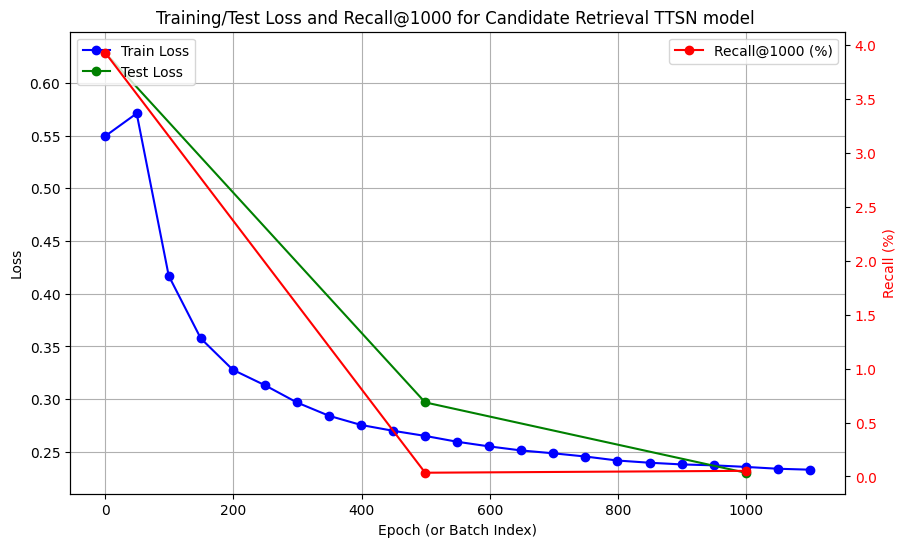

In [213]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace these with your actual recorded data)
# Here, x_values could be batch indices or epoch numbers.

# Create the base plot for loss
fig, ax1 = plt.subplots(figsize=(10, 6))

train_batches, train_losses = zip(*train_loss)
test_batches, test_losses = zip(*test_loss)
recall_batches, recall_values = zip(*recalls)

ax1.plot(train_batches, train_losses, label='Train Loss', color='blue', marker='o')
ax1.plot(test_batches, test_losses, label='Test Loss', color='green', marker='o')
ax1.set_xlabel('Epoch (or Batch Index)')
ax1.set_ylabel('Loss', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a second y-axis for recall
ax2 = ax1.twinx()
# Multiply recall by 100 to show as percentage if desired.
ax2.plot(recall_batches, [r * 100.0 for r in recall_values], label='Recall@1000 (%)', color='red', marker='o')
ax2.set_ylabel('Recall (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('Training/Test Loss and Recall@1000 for Candidate Retrieval TTSN model ')
plt.show()


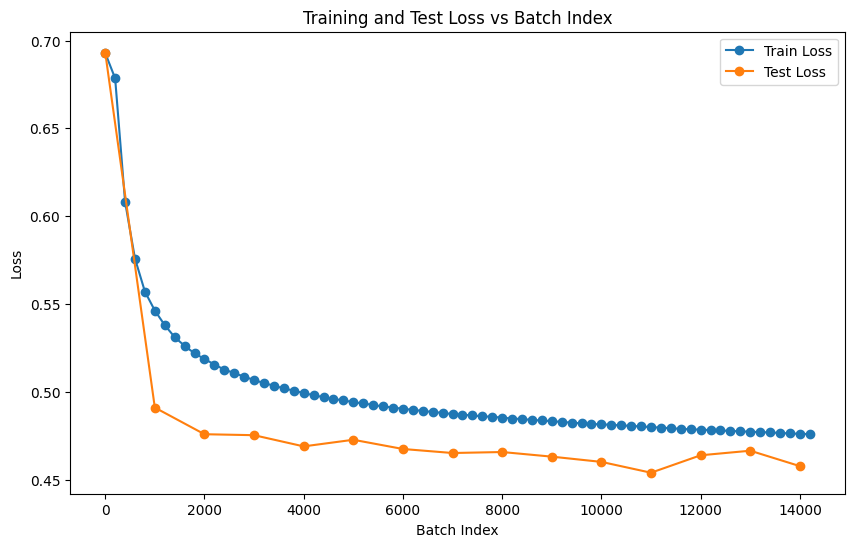

In [149]:
# Extract batch indices and losses for plotting
train_batches, train_losses = zip(*train_loss)
test_batches, test_losses = zip(*test_loss)

plt.figure(figsize=(10, 6))
plt.plot(train_batches, train_losses, label='Train Loss', marker='o')
plt.plot(test_batches, test_losses, label='Test Loss', marker='o')

plt.xlabel('Batch Index')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs Batch Index')
plt.legend()
plt.show()

In [201]:
import torch

# Path to save the checkpoint
checkpoint_path = "./data/two_tower_checkpoint_3_Feb_A.pth"

# Save function
def save_checkpoint(model, optimizer, epoch, loss):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch} with loss {loss:.4f}")

# Example usage (assuming you’re at epoch 5 with some loss value)
save_checkpoint(model, optimizer, epoch=1, loss=0.4759)


Checkpoint saved at epoch 1 with loss 0.4759


# Model Save/Load

In [18]:
import torch

# Load function
def load_checkpoint(model, optimizer, checkpoint_path):
    # Load the saved checkpoint
    checkpoint = torch.load(checkpoint_path)
    
    # Restore model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Retrieve metadata from the checkpoint
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    print(f"Checkpoint loaded from epoch {epoch} with loss {loss:.4f}")
    return model, optimizer, epoch, loss

# Example usage
#model = TwoTowerRecommender(customer_input_dim=13, article_input_dim=544, embedding_dim=32)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Load the checkpoint
model, optimizer, epoch, loss = load_checkpoint(model, optimizer, "./data/two_tower_checkpoint_3_Feb_A.pth")

# Set model to evaluation or training mode depending on the task
#model.eval()  # or model.train() if resuming training


Checkpoint loaded from epoch 20 with loss 0.5192


In [19]:
model

TwoTowerRecommender(
  (customer_tower): Sequential(
    (0): Linear(in_features=13, out_features=254, bias=True)
    (1): ReLU()
    (2): Linear(in_features=254, out_features=254, bias=True)
    (3): ReLU()
    (4): Linear(in_features=254, out_features=32, bias=True)
  )
  (article_tower): Sequential(
    (0): Linear(in_features=544, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=32, bias=True)
  )
)

# TTSN KNN inference

In [20]:
model

TwoTowerRecommender(
  (customer_tower): Sequential(
    (0): Linear(in_features=13, out_features=254, bias=True)
    (1): ReLU()
    (2): Linear(in_features=254, out_features=254, bias=True)
    (3): ReLU()
    (4): Linear(in_features=254, out_features=32, bias=True)
  )
  (article_tower): Sequential(
    (0): Linear(in_features=544, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=32, bias=True)
  )
)

In [260]:
test_data_7d_recall_sampled = test_data_7d_recall.sample(frac=0.02, random_state=42)
recall_customer_features = test_data_7d_recall_sampled.merge(customers_encoded, how="left", on="customer_id")
recall_customer_features_tensor = torch.tensor(customer_training_data_preparation(recall_customer_features[customers_encoded.columns]).values, dtype=torch.float32).to(device)
with torch.no_grad():
    # Pass the customer features through the customer tower.
    user_embeddings = model.customer_tower(recall_customer_features_tensor).cpu().numpy()

import numpy as np
user_norms = np.linalg.norm(user_embeddings, axis=1, keepdims=True)
user_embeddings_norm = user_embeddings / user_norms
user_ids = test_data_7d_recall_sampled.customer_id.values

article_features_tensor = torch.tensor(article_training_data_preparation(articles_categorical).values, dtype=torch.float32).to(device)

with torch.no_grad():
    # Pass the article features through the article tower.
    article_embeddings = model.article_tower(article_features_tensor).cpu().numpy()
    
# Optionally, normalize the embeddings for cosine similarity.
article_norms = np.linalg.norm(article_embeddings, axis=1, keepdims=True)
article_embeddings_norm = article_embeddings / article_norms
article_embeddings_norm

article_ids = articles_categorical.index.to_numpy()
article_ids

In [261]:
test_data_7d_recall_sampled

,customer_id,bought_articles
70921,fe166630e5e67ed3db27d66679c1cf2d4c90a10a9a42c4...,{863937003}
33346,7b9fb26a397db5be7bea2bd36423e8401da543c9c8c12c...,{572998009}
64878,e9881b8361917858b67a3543f20e0a1a728150e92539c0...,"{881112001, 903840002, 573085028, 790368006, 9..."
1213,047686dd8b581ccbd98c6f49aa40f07bad1eb5768782d0...,"{807241057, 912460001, 918725001, 807241001, 7..."
20458,4b9366a00114c9b5df506e3e8a62cabb512c9009350db0...,"{756898003, 857030004}"
...,...,...
39296,91d386c9f7497b0d30ad5f6a278600736af4f9b7a83d7f...,{685814001}
70077,fb1ddf4a453fbfd43854e71abcdd15b2ebfef4709c3cd0...,"{699080001, 804916001, 736923011}"
67663,f2fe7eb015a6ff68eade95ae7d1eb7f1f18741cf03f7b6...,{270381003}
36869,88ee51fed6c213029fbd2255a8ab5b5671194e3ef7c64b...,"{894668003, 834924005}"


In [262]:
recall_customer_features = test_data_7d_recall_sampled.merge(customers_encoded, how="left", on="customer_id")

In [263]:
recall_customer_features_tensor = torch.tensor(customer_training_data_preparation(recall_customer_features[customers_encoded.columns]).values, dtype=torch.float32).to(device)
recall_customer_features_tensor.shape

torch.Size([1429, 13])

In [265]:
with torch.no_grad():
    # Pass the customer features through the customer tower.
    user_embeddings = model.customer_tower(recall_customer_features_tensor).cpu().numpy()

import numpy as np
user_norms = np.linalg.norm(user_embeddings, axis=1, keepdims=True)
user_embeddings_norm = user_embeddings / user_norms
user_embeddings_norm

array([[ 0.16439067, -0.11085542, -0.21051921, ..., -0.14026514,
        -0.1697118 , -0.15989852],
       [ 0.15311469, -0.0793384 , -0.15406252, ..., -0.1744908 ,
        -0.1488602 , -0.19660106],
       [ 0.15309644, -0.0782056 , -0.15367815, ..., -0.17383543,
        -0.14923911, -0.19752917],
       ...,
       [ 0.15347952, -0.08052082, -0.15474558, ..., -0.17480843,
        -0.14833972, -0.19593874],
       [ 0.1648368 , -0.11169806, -0.21050678, ..., -0.13900577,
        -0.16843894, -0.15826668],
       [ 0.153215  , -0.07792622, -0.15360227, ..., -0.17350335,
        -0.14916146, -0.19789937]], shape=(1429, 32), dtype=float32)

In [266]:
user_ids = test_data_7d_recall_sampled.customer_id.values
user_ids.shape

(1429,)

In [253]:
article_features_tensor = torch.tensor(article_training_data_preparation(articles_categorical).values, dtype=torch.float32).to(device)

with torch.no_grad():
    # Pass the article features through the article tower.
    article_embeddings = model.article_tower(article_features_tensor).cpu().numpy()
    
# Optionally, normalize the embeddings for cosine similarity.
article_norms = np.linalg.norm(article_embeddings, axis=1, keepdims=True)
article_embeddings_norm = article_embeddings / article_norms
article_embeddings_norm

array([[ 0.14390376, -0.14015494, -0.22374333, ..., -0.21598653,
        -0.16159661, -0.20017523],
       [ 0.14390376, -0.14015494, -0.22374333, ..., -0.21598653,
        -0.16159661, -0.20017523],
       [-0.17500319,  0.08725829,  0.07353755, ...,  0.06053438,
         0.13185732,  0.08698127],
       ...,
       [-0.1632396 , -0.03450141,  0.0231229 , ...,  0.00942195,
         0.07457127,  0.08508432],
       [-0.16735847,  0.08500639,  0.09479965, ...,  0.11495481,
         0.13763565,  0.12227166],
       [-0.1632396 , -0.03450141,  0.0231229 , ...,  0.00942195,
         0.07457127,  0.08508432]], shape=(105542, 32), dtype=float32)

In [254]:
article_ids = articles_categorical.index.to_numpy()
article_ids

array([108775015, 108775044, 108775051, ..., 956217002, 957375001,
       959461001], shape=(105542,))

In [269]:
ks = [50, 100, 500, 1000, 5000, 10000, 20000]
ks_recalls = []
for k in ks:
    recalls = []
    for idx in range(user_ids.shape[0]):
        if idx % 100 == 0:
            print(idx)
        similarities = np.dot(user_embeddings_norm[idx], article_embeddings_norm.T)
        top_indices_unsorted = np.argpartition(-similarities, kth=k)[:k]
        top_articles_ids = set(article_ids[top_indices_unsorted])
    
        row = test_data_7d_recall_sampled[test_data_7d_recall_sampled['customer_id'] == user_ids[idx]]
        bought_articles = row.iloc[0]['bought_articles']
        num_relevant = len(top_articles_ids.intersection(bought_articles))
        recall = num_relevant / len(bought_articles)
        recalls.append(recall)
    print(k, np.mean(recalls))
    ks_recalls.append(np.mean(recalls))
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
50 0.009013174629813167
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
100 0.016994138926382782
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
500 0.08286322095113126
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1000 0.12725536892445488
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
5000 0.3610771810704702
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
10000 0.5189070490965504
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
20000 0.7145722720436847


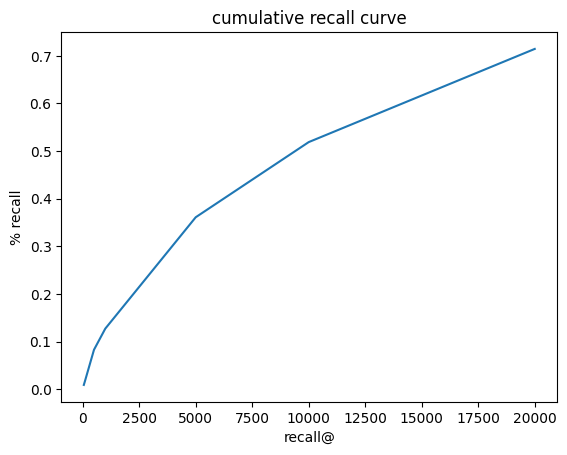

In [277]:
plt.plot(ks, ks_recalls)
plt.title("cumulative recall curve")
plt.xlabel("recall@")
plt.ylabel("% recall")
plt.show()


In [210]:
similarities = np.dot(user_embeddings_norm[0], article_embeddings_norm.T)
similarities

array([ 0.9655213 ,  0.9655213 , -0.88519377, ..., -0.7751029 ,
       -0.9514445 , -0.7751029 ], shape=(105542,), dtype=float32)

In [213]:
top_indices_unsorted = np.argpartition(-similarities, kth=100)[:100]
top_indices_unsorted

array([ 57663,  43695, 104697,  94674,  94525, 101368, 101367, 101366,
        84347,  43697,  43698, 100937, 104555, 101371,  11749,  44410,
        43700,  43701,  43702,  94929,  92135,  43703,  43704,  43705,
        43706,  43707,  43708,  43709,  57082,  43710,  57080,  20739,
        43711,  60507,  81226,  57079,  57075,  57073,  60506,  57071,
        57069,  57067,  57066,  57064,  51537,  51536, 104070,  59773,
        59774, 104946, 104947,  95792,  95791,  60763,  57645,  57647,
        57649,  95790,  57652,  57653,  57654,  57655,  95789,  57656,
        95788,  95787,  95786,  57657,  57660,  11450,  93077,  93076,
        57661,  57662,  57664, 101370,  61759,  12368,  96001,  96000,
        92157,  92156,  45807,  45809,  78102,  12783,   8051,  39238,
       104975,  69729,  12370, 103862,  96061,  64256,  61758,  33283,
       103864, 103863,  64253,  96064])

In [228]:
top_article_ids = article_ids[top_indices_unsorted]

In [236]:
top_article_ids

array([717490081, 677930023, 926164001, 863595006, 863002001, 896152003,
       896152002, 896152001, 815434001, 677930026, 677930027, 893059004,
       924250001, 896161002, 549477005, 679887001, 677930031, 677930037,
       677930060, 864668003, 852584001, 677930062, 677930064, 677930066,
       677930070, 677930072, 677930077, 677930078, 715624054, 677930085,
       715624052, 590178001, 677930086, 729620002, 804992017, 715624051,
       715624036, 715624033, 729620001, 715624012, 715624010, 715624005,
       715624004, 715624002, 699178003, 699178001, 918516001, 724906018,
       724906019, 929165001, 929165002, 867969008, 867969007, 730683050,
       717490010, 717490012, 717490017, 867969006, 717490057, 717490058,
       717490059, 717490060, 867969003, 717490064, 867969002, 867968006,
       867968002, 717490065, 717490075, 547780025, 856667005, 856667004,
       717490076, 717490079, 717490083, 896161001, 734140002, 552866001,
       868629002, 868629001, 852642002, 852642001, 

In [220]:
row = test_data_7d_recall_sampled[test_data_7d_recall_sampled['customer_id'] == user_ids[0]]
row
   

,customer_id,bought_articles
70921,fe166630e5e67ed3db27d66679c1cf2d4c90a10a9a42c4...,{863937003}


In [226]:
bought_articles = row.iloc[0]['bought_articles']
num_relevant = len(top_article_ids.intersection(bought_articles))
num_relevant

0

In [21]:
import pandas as pd
import os
os.listdir('./data')

['customers.csv',
 '.DS_Store',
 'two_tower_checkpoint_1_Feb_A.pth',
 'images',
 'articles.csv',
 'transactions_train.csv',
 'full_training_labels.csv',
 'sample_submission.csv']

In [22]:
submission = pd.read_csv("./data/sample_submission.csv")

In [23]:
customers_encoded

,Active_0,Active_1,FN_0,FN_1,club_member_status_0,club_member_status_1,club_member_status_2,club_member_status_3,fashion_news_frequency_0,fashion_news_frequency_1,fashion_news_frequency_2,fashion_news_frequency_3,age
customer_id,,,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,True,False,True,False,True,False,False,False,True,False,False,False,0.49
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,True,False,True,False,True,False,False,False,True,False,False,False,0.25
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,True,False,True,False,True,False,False,False,True,False,False,False,0.24
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,True,False,True,False,True,False,False,False,True,False,False,False,0.54
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,False,True,False,True,True,False,False,False,False,True,False,False,0.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831,True,False,True,False,True,False,False,False,True,False,False,False,0.24
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7,True,False,True,False,True,False,False,False,True,False,False,False,0.21
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264,False,True,False,True,True,False,False,False,False,True,False,False,0.21


In [24]:
articles_categorical

,product_type_no_-1,product_type_no_49,product_type_no_57,product_type_no_59,product_type_no_60,product_type_no_66,product_type_no_67,product_type_no_68,product_type_no_69,product_type_no_70,...,garment_group_no_1013,garment_group_no_1014,garment_group_no_1016,garment_group_no_1017,garment_group_no_1018,garment_group_no_1019,garment_group_no_1020,garment_group_no_1021,garment_group_no_1023,garment_group_no_1025
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
108775044,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
108775051,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
110065001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
110065002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953450001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
953763001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
956217002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [25]:
submission_uniques = set(list(submission.customer_id))

In [26]:
with_features_uniques = set(list(customers_encoded.index))

In [27]:
intersect_user = set()
for u in submission_uniques:
    if u in with_features_uniques:
        intersect_user.add(u)
len(intersect_user), len(submission_uniques)
    

(1371980, 1371980)

In [184]:
model.eval()

# Choose device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

TwoTowerRecommender(
  (customer_tower): Sequential(
    (0): Linear(in_features=13, out_features=254, bias=True)
    (1): ReLU()
    (2): Linear(in_features=254, out_features=254, bias=True)
    (3): ReLU()
    (4): Linear(in_features=254, out_features=32, bias=True)
  )
  (article_tower): Sequential(
    (0): Linear(in_features=544, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=32, bias=True)
  )
)

In [29]:
customer_features_tensor = torch.tensor(customer_training_data_preparation(customers_encoded).values, dtype=torch.float32).to(device)

In [30]:
model.customer_tower

Sequential(
  (0): Linear(in_features=13, out_features=254, bias=True)
  (1): ReLU()
  (2): Linear(in_features=254, out_features=254, bias=True)
  (3): ReLU()
  (4): Linear(in_features=254, out_features=32, bias=True)
)

In [31]:
with torch.no_grad():
    # Pass the customer features through the customer tower.
    user_embeddings = model.customer_tower(customer_features_tensor).cpu().numpy()


In [32]:
user_embeddings

array([[-0.85064954,  0.31157956, -0.8300066 , ...,  0.2639706 ,
        -0.4330371 , -0.40653935],
       [-0.89938474,  0.3308437 , -0.8923209 , ...,  0.31257948,
        -0.48788214, -0.4512458 ],
       [-0.90183145,  0.33186796, -0.8954547 , ...,  0.31488574,
        -0.49053437, -0.45337144],
       ...,
       [-1.124307  ,  0.45182127, -0.9012944 , ..., -0.04307365,
        -0.5136422 , -0.3285176 ],
       [-1.1330011 ,  0.4547561 , -0.91250473, ..., -0.03712555,
        -0.52018505, -0.3339882 ],
       [-0.67588615,  0.24325137, -0.657035  , ...,  0.23697528,
        -0.32734242, -0.30164382]], shape=(1371980, 32), dtype=float32)

In [33]:
import numpy as np
user_norms = np.linalg.norm(user_embeddings, axis=1, keepdims=True)
user_embeddings_norm = user_embeddings / user_norms

In [34]:
user_embeddings_norm

array([[-0.3090014 ,  0.11318235, -0.30150276, ...,  0.09588824,
        -0.15730223, -0.14767683],
       [-0.2983572 ,  0.10975236, -0.29601386, ...,  0.10369349,
        -0.16184747, -0.14969394],
       [-0.2978915 ,  0.10962208, -0.29578513, ...,  0.10401254,
        -0.16203251, -0.14975691],
       ...,
       [-0.36317998,  0.14594986, -0.29114118, ..., -0.01391389,
        -0.16591959, -0.1061196 ],
       [-0.36146504,  0.14508232, -0.29111937, ..., -0.01184428,
        -0.16595635, -0.10655335],
       [-0.31034404,  0.11169279, -0.30168822, ...,  0.10881102,
        -0.15030456, -0.13850462]], shape=(1371980, 32), dtype=float32)

In [37]:
user_embeddings_norm.shape[1]

32

In [43]:
customer_ids = customers_encoded.index.to_numpy()

In [44]:
import numpy as np

# Assume these are your computed embeddings and user IDs:
# user_embeddings: shape (num_users, embedding_dim), dtype=float32
# user_ids: a NumPy array (or list) with the corresponding user IDs

# Save both arrays in a single compressed file.
np.savez("./data/customer_embeddings.npz", customer_ids=customer_ids, customer_embeddings=user_embeddings_norm)


In [35]:
article_features_tensor = torch.tensor(article_training_data_preparation(articles_categorical).values, dtype=torch.float32).to(device)

with torch.no_grad():
    # Pass the article features through the article tower.
    article_embeddings = model.article_tower(article_features_tensor).cpu().numpy()
    
# Optionally, normalize the embeddings for cosine similarity.
article_norms = np.linalg.norm(article_embeddings, axis=1, keepdims=True)
article_embeddings_norm = article_embeddings / article_norms

In [36]:
article_embeddings_norm

array([[-0.36891812,  0.24483952, -0.29774725, ...,  0.04456037,
        -0.12046511, -0.13389552],
       [-0.36891812,  0.24483952, -0.29774725, ...,  0.04456037,
        -0.12046511, -0.13389552],
       [-0.37447694,  0.26960835, -0.31746832, ...,  0.03273991,
        -0.0709398 , -0.10418003],
       ...,
       [-0.28365773,  0.26439938, -0.19779333, ..., -0.12383389,
        -0.02610125, -0.0189227 ],
       [-0.12732163,  0.1491909 , -0.1390557 , ..., -0.13230626,
         0.07885028,  0.04837248],
       [-0.28365773,  0.26439938, -0.19779333, ..., -0.12383389,
        -0.02610125, -0.0189227 ]], shape=(105542, 32), dtype=float32)

In [45]:
articles_categorical.index.to_numpy()

array([108775015, 108775044, 108775051, ..., 956217002, 957375001,
       959461001], shape=(105542,))

In [46]:
article_ids = articles_categorical.index.to_numpy()

In [47]:
np.savez("./data/article_embeddings.npz", article_ids=article_ids, article_embeddings=article_embeddings_norm)

In [35]:
np.dot(user_embeddings_norm[0], article_embeddings_norm.T)

array([ 0.9496318 ,  0.9496318 ,  0.83290476, ...,  0.3046106 ,
       -0.12626183,  0.3046106 ], shape=(105542,), dtype=float32)

In [36]:
similarities = np.dot(user_embeddings_norm[0], article_embeddings_norm.T)

In [37]:
np.argpartition(-similarities, kth=12)

array([ 95844,  61602,  95843, ...,     11, 105540,  52770],
      shape=(105542,))

In [38]:
articles_categorical.reset_index().iloc[95844].article_id

np.int64(868063004)

In [39]:
import faiss
import numpy as np
import pandas as pd

# Assume your user and article embeddings are already normalized
# user_embeddings_norm: (num_users, embedding_dim)
# article_embeddings_norm: (num_articles, embedding_dim)
# articles_categorical: original DataFrame indexed by article_id

# Reset the index to ensure article_id is accessible as a column
articles_categorical_reset = articles_categorical.reset_index()

# Prepare FAISS index
embedding_dim = article_embeddings_norm.shape[1]  # Should be 32 (or your embedding size)
index = faiss.IndexFlatIP(embedding_dim)  # Inner product index for cosine similarity
index.add(article_embeddings_norm.astype(np.float32))  # Add all article embeddings


In [40]:
article_embeddings_norm

array([[-0.36891812,  0.24483952, -0.29774725, ...,  0.04456037,
        -0.12046511, -0.13389552],
       [-0.36891812,  0.24483952, -0.29774725, ...,  0.04456037,
        -0.12046511, -0.13389552],
       [-0.37447694,  0.26960835, -0.31746832, ...,  0.03273991,
        -0.0709398 , -0.10418003],
       ...,
       [-0.28365773,  0.26439938, -0.19779333, ..., -0.12383389,
        -0.02610125, -0.0189227 ],
       [-0.12732163,  0.1491909 , -0.1390557 , ..., -0.13230626,
         0.07885028,  0.04837248],
       [-0.28365773,  0.26439938, -0.19779333, ..., -0.12383389,
        -0.02610125, -0.0189227 ]], shape=(105542, 32), dtype=float32)

In [43]:
user_embeddings_norm

array([[-0.3090014 ,  0.11318235, -0.30150276, ...,  0.09588824,
        -0.15730223, -0.14767683],
       [-0.2983572 ,  0.10975236, -0.29601386, ...,  0.10369349,
        -0.16184747, -0.14969394],
       [-0.2978915 ,  0.10962208, -0.29578513, ...,  0.10401254,
        -0.16203251, -0.14975691],
       ...,
       [-0.36317998,  0.14594986, -0.29114118, ..., -0.01391389,
        -0.16591959, -0.1061196 ],
       [-0.36146504,  0.14508232, -0.29111937, ..., -0.01184428,
        -0.16595635, -0.10655335],
       [-0.31034404,  0.11169279, -0.30168822, ...,  0.10881102,
        -0.15030456, -0.13850462]], shape=(1371980, 32), dtype=float32)

In [73]:
index

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x31ba4eb50> >

In [71]:
pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:

# Top-k articles
k = 12

# Perform search for all user embeddings at once
distances, indices = index.search(user_embeddings_norm.astype(np.float32), k)

In [ ]:
import numpy as np
import faiss
import pandas as pd

# Assume these are already computed:
# - user_embeddings_norm: (num_users, embedding_dim) normalized user embeddings.
# - article_embeddings_norm: (num_articles, embedding_dim) normalized article embeddings.
# - customers_encoded: DataFrame whose index contains customer IDs in the same order as user_embeddings_norm.
# - articles_categorical: DataFrame indexed on article_id with article features.

# Reset articles_categorical index so that the article IDs become a column and rows are sequential.
articles_categorical_reset = articles_categorical.reset_index()
article_ids = articles_categorical_reset['article_id'].values

# Build the FAISS index
embedding_dim = article_embeddings_norm.shape[1]
index = faiss.IndexFlatIP(embedding_dim)  # Inner product index (works as cosine similarity if vectors are normalized)
index.add(article_embeddings_norm.astype(np.float32))

# Set the number of top articles to retrieve per user
k = 12

# Set a batch size (adjust based on available memory)
batch_size = 10000
num_users = user_embeddings_norm.shape[0]
num_batches = (num_users + batch_size - 1) // batch_size

# File to save recommendations
output_file = "recommendations_batches.csv"

# Write header to file
with open(output_file, 'w') as f:
    f.write("customer_id,recommended_articles\n")

# Process users in batches
for i in range(num_batches):
    start = i * batch_size
    end = min((i + 1) * batch_size, num_users)
    
    # Extract a batch of user embeddings
    batch_user_embeddings = user_embeddings_norm[start:end]
    
    # Perform the FAISS search for the batch (note: cast to float32)
    distances, indices = index.search(batch_user_embeddings.astype(np.float32), k)
    
    # Map indices back to actual article IDs
    recommended_article_ids = article_ids[indices]  # shape: (batch_size, k)
    
    # Get the corresponding customer IDs from customers_encoded (assumed to be in order)
    batch_customer_ids = customers_encoded.index.values[start:end]
    
    # Prepare the batch results
    batch_results = []
    for j, cust_id in enumerate(batch_customer_ids):
        # Convert the list of recommended article IDs into a comma-separated string
        recs_str = ",".join(map(str, recommended_article_ids[j].tolist()))
        batch_results.append([cust_id, recs_str])
    
    # Convert the batch results to a DataFrame and append to CSV
    df_batch = pd.DataFrame(batch_results, columns=["customer_id", "recommended_articles"])
    df_batch.to_csv(output_file, mode='a', index=False, header=False)
    
    print(f"Batch {i+1}/{num_batches} processed (users {start} to {end-1}).")

print(f"All batches processed. Recommendations saved to {output_file}")
